# Eddy Current Brake
This script is to replicate the analytical plot in Fig. 6 of the 2019 journal paper 'Characteristic Analysis of the Peak Braking Force and the Critical Speed of Eddy Current Braking in a High-Speed Maglev' authored by Chuntao Chen, Jie Xu, Xibo Yuan and Xinzhen Wu. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Constants
MU0 = 4 * np.pi * 10**(-7)   # Permeability of free space in H/m

# Model parameters
p = 6                        # Number of pole pairs (no unit)
vmax = 272                   # Maximum operating speed in m/s
j = 1.2 * 10**7              # Exciting current density in A/m2
kf = 0.687                   # Fill factor of coil slot (no unit)
bc = 0.0153                  # Width of exciting coil in m
hc = 0.115                   # Height of exciting coil in m
tau = 0.1                    # Pole pitch in m 
delta = 0.01                 # Air gap length in m
bp = 0.0692                  # Pole width in m
bg = 0.005                   # Thickness of induction plate in m
w = 0.2                      # Model depth in m
sigma = 10**6                # Induction plate conductivity in S/m

# Variables
v = np.linspace(0,vmax,76)  # Velocity in m/s
no = np.array([1,3,5])      # Number of harmonic (no unit)

In [3]:
# Calculate Carter coefficient and modified air gap length

coef = (tau - bp) / (2 * delta)   # Sumarise quotient for use below
gamma = 4 / np.pi * (coef * np.arctan(coef) - np.log(np.sqrt(1 + coef**2)))
kc = tau / (tau - gamma * delta)  # Carter coefficient (no unit)
deltamod = delta * kc             # Modified air gap length in m 

In [4]:
# Calculate total length of eddy current braking device 

lp = 2 * p * tau  # Total length in m

In [5]:
# Calculate components an of Fourier decomposition

def integ(upper,lower):
    """ Calculates a definite integral of the form occuring  
    in equation 15 in a specified inteval.
    upper ... upper boundary of the interval
    lower ... lower boundary of the interval
    """
    return (1/npitau * (np.sin(npitau * upper) - np.sin(npitau * lower)))

fw = np.zeros([len(v)])
fwstore = np.zeros([len(no),len(v)])

for i in range(0,len(no)):
    S = hc * bc * kf           # Cross-sectional area of exciting coil in m**2
    # S = np.pi / 4 * bp**2    # Cross-sectional area of exciting coil in m**2
    c = tau - (2 * bc + bp)    # Gap between coils in m
    npitau = no[i] * np.pi / tau   # Sumarise quotient for later use
    b = j * S * kf / bc        # Linear current density constant in A/m
    k = np.pi / tau * (integ(c/2+bc, c/2) - integ(tau-c/2, tau-(c/2+bc))) 
    an = 2 * b * k / np.pi    

    # Calculate the nth harmonic of the braking force FWn

    summand = npitau * np.sqrt( npitau**2 + MU0**2 * sigma**2 * v**2)
    m = np.sqrt((npitau**2 + summand) / 2)
    n = np.sqrt((-npitau**2 + summand) / 2)

    y1 = np.cosh(npitau * deltamod) * np.sinh(m * bg) * np.cos(n * bg)
    y2 = np.cosh(npitau * deltamod) * np.cosh(m * bg) * np.sin(n * bg)
    y3 = np.sinh(npitau * deltamod) * np.cosh(m * bg) * np.cos(n * bg)
    y4 = np.sinh(npitau * deltamod) * np.sinh(m * bg) * np.sin(n * bg)

    fwn = -(npitau * lp * w * MU0 * an**2 * (m * np.sin(2 * n * bg) \
                                             + n * np.sinh(2 * m * bg))) \
           / (2 * ((m * y1 - n * y2 + npitau * y3)**2 \
                 + (m * y2 + n * y1 + npitau * y4)**2))
    fwstore[i,:] = fwn
    fw = fw + fwstore[i,:]

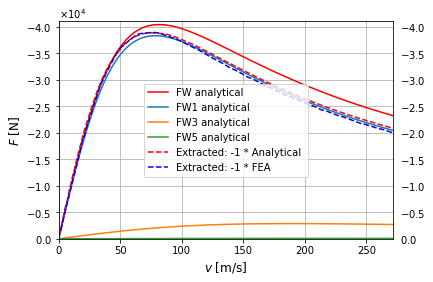

In [6]:
# Import extracted data from paper 
# Data has been extracted via WebPlotDigitizer 

ana = pd.read_csv('figure6_AnalyticalSolution_WebPlotDigitizer_AutomaticExtraction_Win10px10px.csv')
fea = pd.read_csv('figure6_FEASolution_WebPlotDigitizer_AutomaticExtraction_Win10px10px.csv')

# Plot results

xtitle = '$v$ [m/s]'
ytitle = '$F$ [N]'

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(v, fw, color='red', label='FW analytical')
for i in range(0,len(no)):
    ax.plot(v, fwstore[i,:], label='FW{} analytical'.format(no[i])) 
ax.plot(ana['v'],-ana['F'], color='red', linestyle='dashed', label='Extracted: -1 * Analytical ')
ax.plot(fea['v'],-fea['F'], color='blue', linestyle='dashed', label='Extracted: -1 * FEA')
ax.set_xlabel(xtitle, fontsize='large')
ax.set_ylabel(ytitle, fontsize='large')
ax.set_xlim([0,vmax])
ax.set_ylim([0,-4.1*10**4])
ax.legend()
ax.grid()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax.tick_params(labelright=True)

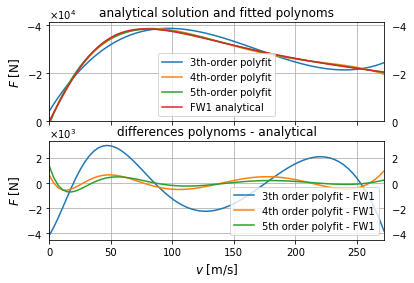

In [7]:
# Create a polynomial fits for the 1st harmonic and compare to analytical result
# Plot the differences between analytical and fitted curves

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.set_title('analytical solution and fitted polynoms')
for i in range(3,6):
    fitcoef = np.polyfit(v,fwstore[0,:],i)
    fit = np.poly1d(fitcoef)
    ax1.plot(v,fit(v), label='{}th-order polyfit'.format(i))
    ax2.plot(v,fit(v)-fwstore[0,:], label='{}th order polyfit - FW1'.format(i))
ax1.plot(v, fwstore[0,:], label='FW1 analytical')
ax1.set_ylabel(ytitle, fontsize='large')
ax1.set_xlim([0,vmax])
ax1.set_ylim([0,-4.1*10**4])
ax1.legend()
ax1.grid()
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax1.tick_params(labelright=True)

ax2.set_title('differences polynoms - analytical')
ax2.set_ylabel(ytitle, fontsize='large')
ax2.set_xlabel(xtitle, fontsize='large')
ax2.legend()
ax2.grid()
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax2.tick_params(labelright=True)